In [ ]:
import numpy as np
import cv2
from segment_anything import SamPredictor, sam_model_registry
from skimage import io
from matplotlib import pyplot as plt

import torch

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images

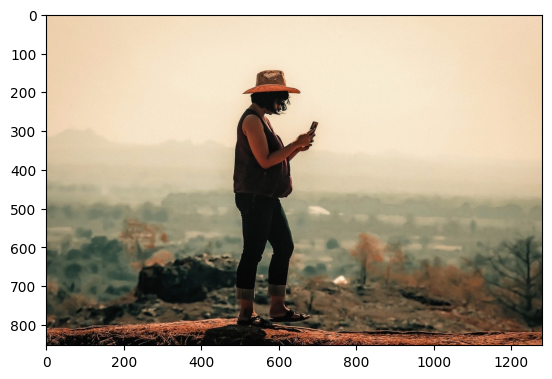

In [ ]:
img = img = io.imread('pictures/woman.jpg')
plt.imshow(img)
plt.show()

Segment Anything

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

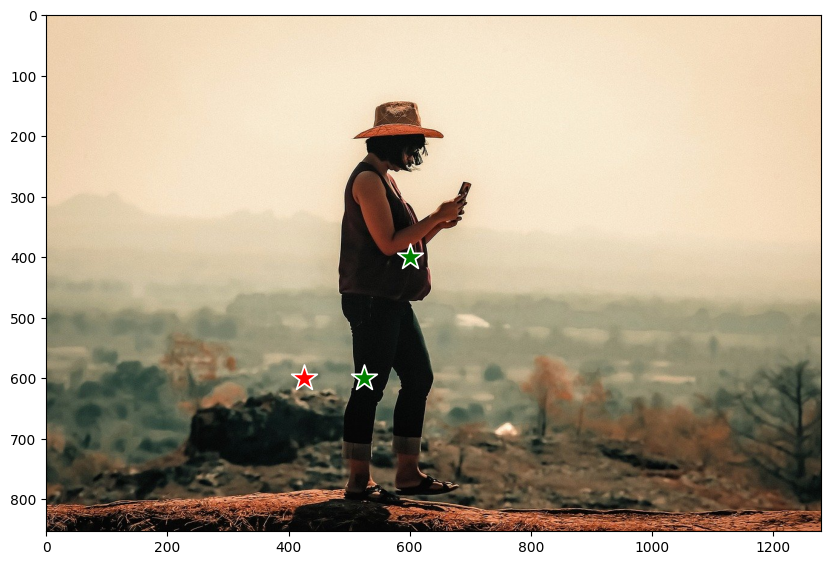

In [ ]:
import sys
sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(img)

input_point = np.array([[600, 400], [525, 600], [425, 600]])
input_label = np.array([1, 1, 0])


plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  


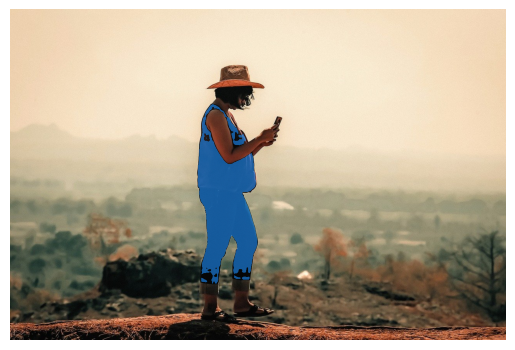

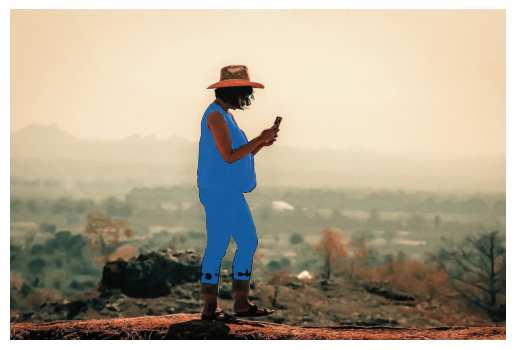

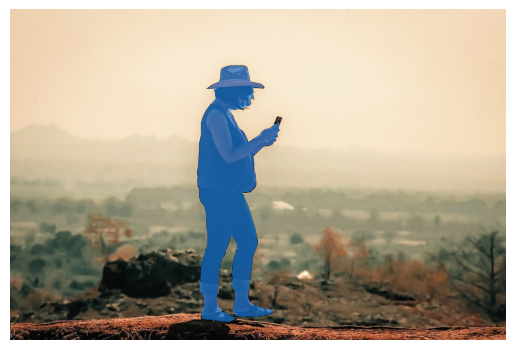

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

masks.shape 

best_mask = masks
currentScore = 0

for i, (mask, score) in enumerate(zip(masks, scores)):
    #plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    #show_points(input_point, input_label, plt.gca())
    #plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
    if (score > currentScore):
        currentScore = score
        best_mask = mask

segment_img = img


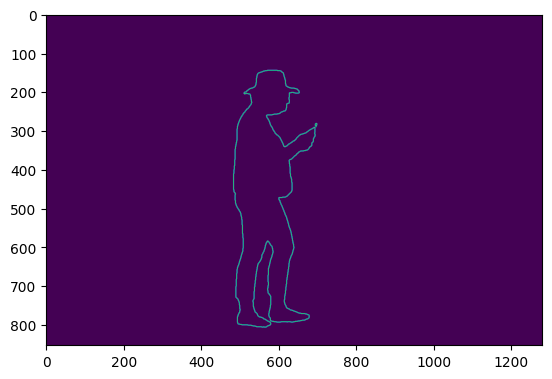

In [ ]:
edge_sobel = filters.sobel(best_mask)
plt.imshow(edge_sobel)
plt.show()

Bild anhand dieser Konturen ausschneiden

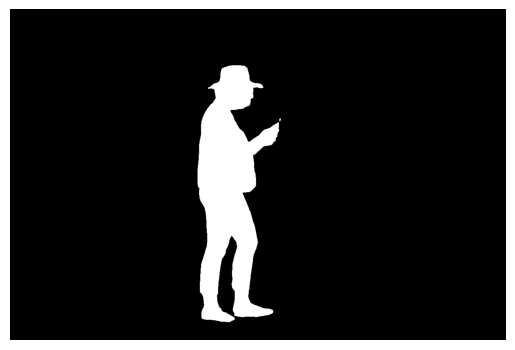

In [ ]:
plt.imshow(best_mask, cmap="gray")
plt.axis('off')
plt.show()

## cutting the image

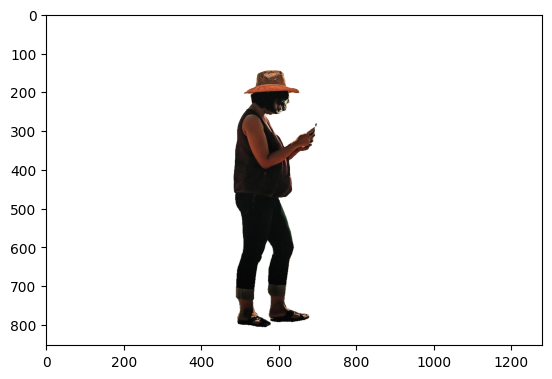

In [ ]:

from PIL import Image, ImageOps

# Convert to grayscale
mask = Image.fromarray(best_mask)

# Threshold and invert the colors (white will be transparent)
mask = mask.point(lambda x: x > 100 and 255)

# The size of the images must match before apply the mask
img = ImageOps.fit(Image.open('pictures/woman.jpg'),mask.size)

img.putalpha(mask) # Modifies the original image without return

#img.save('result2.png')
plt.imshow(img)
plt.show()


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    i = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    i[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.8]])
        i[m] = color_mask
    ax.imshow(i)
    return i

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

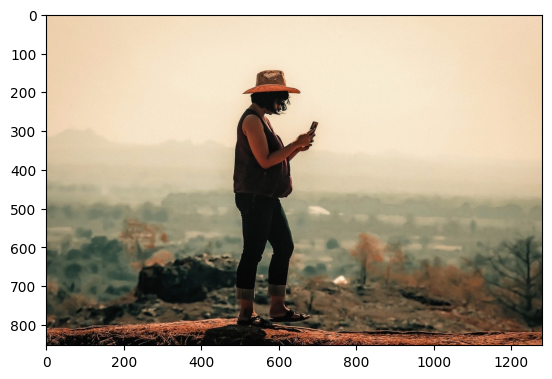

In [ ]:
from numpy import array


image2 = cv2.imread('result2.png')
#image2 = cv2.cvtColor(array(img), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.imshow(image2)
plt.show()


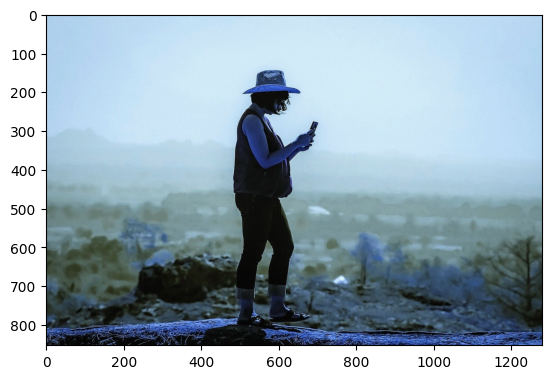

In [ ]:
image2 = cv2.cvtColor(array(img), cv2.COLOR_BGR2RGB)
plt.imshow(image2)
plt.show()

In [60]:
masks = mask_generator.generate(image2)
print(len(masks))
print(masks[0].keys())

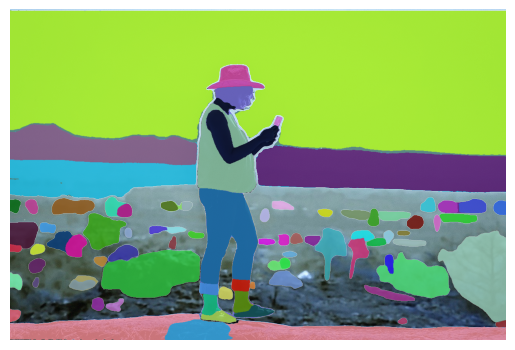

In [ ]:
#plt.figure(figsize=(20,20))
#plt.imshow(img)
test = show_anns(masks)
plt.axis('off')
plt.show()

Functions to visualize the pose estimation results

plt.figure(figsize=(10,10))
plt.imshow(img)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 